## Classification using all available data (10016 images) - using Class weights for balancing


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob #to walk through folder structure
import seaborn as sns
from PIL import Image #image loading,resize
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import autokeras as ak
np.random.seed(42)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
import warnings
warnings.filterwarnings("ignore")

In [19]:
from tensorflow.keras.models import load_model

In [2]:
skin_df = pd.read_csv('data/HAM10000_metadata.csv')

In [3]:
# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [4]:
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))

        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extremity      5  
8984  lower extremity      5  
2310 

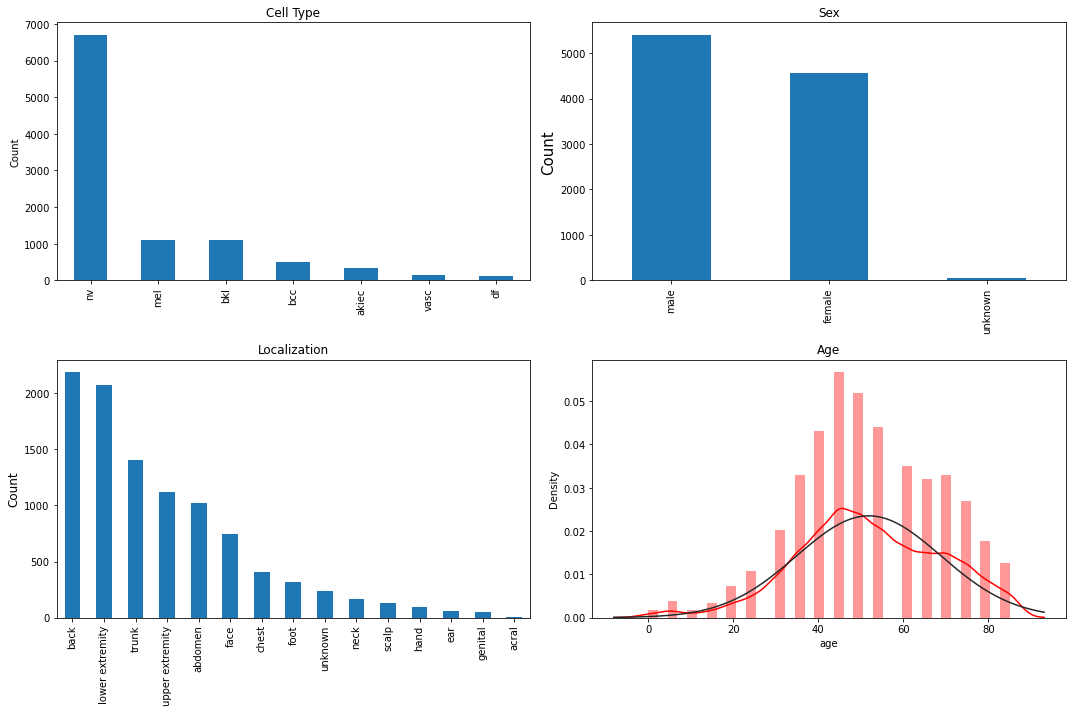

In [5]:
# Data distribution visualization
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')


ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [7]:
# Distribution of data into various classes 
from sklearn.utils import resample
print(skin_df['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


In [49]:
from sklearn.utils import class_weight
import numpy as np

In [38]:
# use all data
print(skin_df.head(1))

     lesion_id      image_id   dx dx_type   age   sex localization  label
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp      2


In [39]:
from keras.preprocessing.image import ImageDataGenerator

In [57]:
#Define datagen. Here we can define any transformations we want to apply to images
datagen = ImageDataGenerator(rescale=1./255,
                            validation_split=0.2)

# define training directory that contains subfolders
train_dir = os.getcwd() + "/data/HAM10000_organised/"
#USe flow_from_directory
traingen = datagen.flow_from_directory(directory=train_dir,
                                         class_mode='categorical',
                                         batch_size=32,  #16 images at a time
                                         target_size=(32,32),
                                         subset='training',)  #Resize images
testgen = datagen.flow_from_directory(directory=train_dir,
                                         class_mode='categorical',
                                         batch_size=32,  #16 images at a time
                                         target_size=(32,32),
                                         subset='validation',)  #Resize images

Found 8015 images belonging to 7 classes.
Found 2000 images belonging to 7 classes.


In [58]:
#We can check images for a single batch.
x, y = next(traingen)
print(x.shape)
print(y.shape)

(32, 32, 32, 3)
(32, 7)


In [53]:
np.unique(traingen.classes)

array([0, 1, 2, 3, 4, 5, 6])

In [59]:
class_weights = dict(zip(np.unique(traingen.classes),class_weight.compute_class_weight(
                        class_weight = 'balanced',
                        classes = np.unique(traingen.classes), 
                        y = traingen.classes)))

In [60]:
class_weights

{0: 4.370229007633588,
 1: 2.779126213592233,
 2: 1.3011363636363635,
 3: 12.445652173913043,
 4: 1.2850729517396184,
 5: 0.21346010439970173,
 6: 10.043859649122806}

In [66]:
nb_epochs = 10

In [65]:
traingen.samples//32

250

In [80]:
testgen.samples//32

62

In [68]:
history = model.fit_generator(
    traingen,
#     steps_per_epoch = traingen.samples // batch_size,
    validation_data = testgen, 
#     validation_steps = testgen.samples // batch_size,
    epochs = nb_epochs,
    verbose = 2)

C:\Users\Shailu\AppData\Local\Temp\ipykernel_6084\709978231.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
251/251 - 86s - loss: 0.6748 - acc: 0.7439 - val_loss: 0.5924 - val_acc: 0.7660 - 86s/epoch - 343ms/step
Epoch 2/10
251/251 - 89s - loss: 0.6594 - acc: 0.7480 - val_loss: 0.5983 - val_acc: 0.7710 - 89s/epoch - 355ms/step
Epoch 3/10
251/251 - 94s - loss: 0.6586 - acc: 0.7512 - val_loss: 0.5910 - val_acc: 0.7770 - 94s/epoch - 376ms/step
Epoch 4/10
251/251 - 101s - loss: 0.6496 - acc: 0.7493 - val_loss: 0.5898 - val_acc: 0.7830 - 101s/epoch - 401ms/step
Epoch 5/10
251/251 - 115s - loss: 0.6480 - acc: 0.7530 - val_loss: 0.5916 - val_acc: 0.7670 - 115s/epoch - 459ms/step
Epoch 6/10
251/251 - 113s - loss: 0.6414 - acc: 0.7545 - val_loss: 0.5954 - val_acc: 0.7720 - 113s/epoch - 451ms/step
Epoch 7/10
251/251 - 103s - loss: 0.6440 - acc: 0.7505 - val_loss: 0.5982 - val_acc: 0.7755 - 103s/epoch - 411ms/step
Epoch 8/10
251/251 - 112s - loss: 0.6366 - acc: 0.7546 - val_loss: 0.5936 - val_acc: 0.7655 - 112s/epoch - 446ms/step
Epoch 9/10
251/251 - 114s - loss: 0.6219 - acc: 0.7606 - val_l

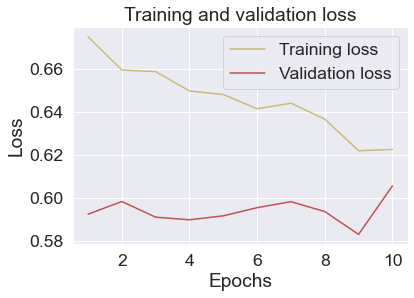

In [69]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


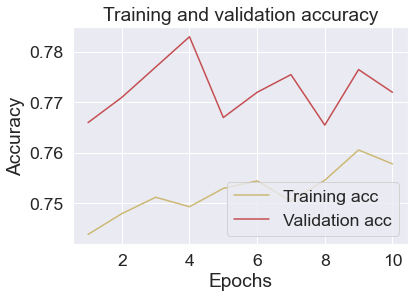

In [70]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [73]:
# Prediction on test data
predict = model.predict(testgen)

63/63 [==============================] - 14s 226ms/step


In [76]:
np.argmax(predict,axis=1)

array([5, 6, 5, ..., 5, 5, 5], dtype=int64)

In [79]:
testgen.class_indices.keys()

dict_keys(['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'])

In [91]:
x,y = next(testgen)

In [95]:
from collections import Counter
Counter(np.argmax(y,axis=1))

Counter({5: 21, 4: 6, 1: 4, 2: 1})

In [84]:
# test_labels

In [86]:
len(testgen.labels)

2000

In [87]:
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(predict, axis = 1) 
# Convert test data to one hot vectors
y_true = testgen.labels 

In [88]:
cm = confusion_matrix(y_true, y_pred_classes)

<AxesSubplot:>

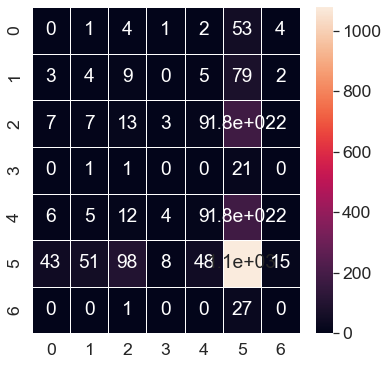

In [89]:
fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

Text(0, 0.5, 'Fraction of incorrect predictions')

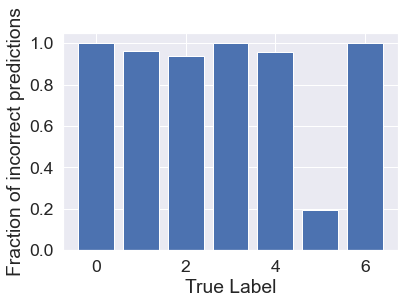

In [90]:
#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')